## 📊 Dataset Exploration (Google Landmarks Dataset)

In this section, we explored the **Google Landmarks Dataset (GLDv2)**, which contains millions of images of landmarks from around the world. Each image is labeled with:

- **`id`** → Unique identifier for the image  
- **`landmark_id`** → Numerical ID assigned to the landmark  
- **`category`** → Human-readable class/category describing the landmark type  
- **`image`** → The actual image data  
- **`label`** → The landmark label mapped from `landmark_id`  

---

### ✅ Steps Performed
1. **Loaded the Dataset**  
   - Imported the dataset containing metadata for landmark images.  
   - Verified dataset structure and checked the first few rows.  

2. **Merged Landmark Names (if available)**  
   - Combined the training metadata with the `landmarks.csv` file to map `landmark_id` → landmark name.  
   - This allows us to work with *human-readable names* instead of just numerical IDs.  

3. **Visualized Samples**  
   - Displayed random sample images with their `id`, `landmark_id`, `category`, and `label`.  
   - Verified that the dataset is correctly loaded and images are accessible.  

4. **Extracted Categories**  
   - Pulled out all unique values from the `category` column.  
   - Sorted them to see the distinct landmark types represented in the dataset.  

---

### 📂 Categories
We found that the dataset includes the following unique **categories**:

- A set of human-readable classes (such as *historical_building, museum, natural_site*, etc.).  
- These categories help us better understand the **semantic grouping** of the landmarks beyond just their IDs.  

This prepares us for the next stage: **EDA & Visualization**, where we will analyze the number of images per category and check dataset balance.


In [1]:
# Basic setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
from PIL import Image
from io import BytesIO

# For visualization
import seaborn as sns
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import io


## download dataset for egypt

In [2]:

!pip install -q roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 117.9 MB/s eta 0:00:00


In [3]:
# !pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="N79o2Kg5Jx1ItlvgpiNN")
project = rf.workspace("gp-j4r5m").project("augmented-iklfg")
version = project.version(1)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to augmented-1 in yolov11:: 100%|██████████| 27764/27764 [00:08<00:00, 3267.26it/s]


In [4]:
import os
import glob
import collections
import shutil
from sklearn.model_selection import train_test_split

In [5]:
def get_top_classes(dataset_path, top_n=35):




    label_files = glob.glob(os.path.join(dataset_path,"**", "labels", "*.txt"), recursive=True)

    class_counts = collections.Counter()
    for lf in label_files:
        with open(lf, "r") as f:
            for line in f:
                if line.strip():
                    cid = int(line.split()[0])
                    class_counts[cid] += 1
    return [cid for cid, _ in class_counts.most_common(top_n)]

In [6]:
def collect_class_subset(dataset_path, selected_classes):
    all_images, all_labels = [], []



    label_files = glob.glob(os.path.join(dataset_path,"**", "labels", "*.txt"), recursive=True)


    for lf in label_files:
        with open(lf, "r") as f:
            lines = f.readlines()
            if not lines:
                continue
            cid = int(lines[0].split()[0])
            if cid in selected_classes:
                base = os.path.splitext(os.path.basename(lf))[0]


                img_candidates = glob.glob(os.path.join(dataset_path, "**", "images", base + ".*"), recursive=True)

                # img_candidates = glob.glob(os.path.join(dataset_path, "images", "**", base + ".*"), recursive=True)
                if img_candidates:
                    all_images.append(img_candidates[0])
                    all_labels.append(lf)
    return all_images, all_labels

In [7]:
def merge_datasets(egypt_path,output_path, top_n=35):
    # 1) احسب أعلى 20 من كل واحدة
    top20_egypt = get_top_classes(egypt_path, top_n=top_n)
    print("📌 Top 20 Egypt:", top20_egypt)

    # 2) جمع الصور والليبلز
    imgs_egypt, lbls_egypt = collect_class_subset(egypt_path, top20_egypt)

    all_images = imgs_egypt
    all_labels = lbls_egypt

    print(f"📊 Collected {len(all_images)} images total")

    # 3) Split train/test
    train_imgs, test_imgs, train_lbls, test_lbls = train_test_split(
        all_images, all_labels, test_size=0.2, random_state=42,shuffle=True
    )

    # 4) أنشئ المجلدات
    for split in ["train", "test"]:
        os.makedirs(os.path.join(output_path, "images", split), exist_ok=True)
        os.makedirs(os.path.join(output_path, "labels", split), exist_ok=True)

    # 5) نسخ train
    for img, lbl in zip(train_imgs, train_lbls):
        shutil.copy(img, os.path.join(output_path, "images", "train", os.path.basename(img)))
        shutil.copy(lbl, os.path.join(output_path, "labels", "train", os.path.basename(lbl)))

    # 6) نسخ test
    for img, lbl in zip(test_imgs, test_lbls):
        shutil.copy(img, os.path.join(output_path, "images", "test", os.path.basename(img)))
        shutil.copy(lbl, os.path.join(output_path, "labels", "test", os.path.basename(lbl)))

    print(f"✅ Done! {len(train_imgs)} train + {len(test_imgs)} test saved in {output_path}")


In [9]:
# ---------- تنفيذ ----------
egypt_path = "/content/augmented-1"
output_path = "/content/Merged_Top20_YOLO"

merge_datasets(egypt_path, output_path, top_n=35)

📌 Top 20 Egypt: [19, 53, 24, 36, 5, 44, 41, 2, 82, 72, 34, 32, 0, 80, 62, 70, 56, 27, 69, 1, 29, 16, 66, 14, 71, 60, 23, 46, 15, 42, 13, 55, 64, 78, 38]
📊 Collected 10646 images total
✅ Done! 8516 train + 2130 test saved in /content/Merged_Top20_YOLO


In [10]:
import os
import glob

# number of images and classes in Merged_Top20_YOLO Dataset

dataset_path = "/content/Merged_Top20_YOLO"

img_files = glob.glob(os.path.join(dataset_path, "images", "**", "*.jpg"), recursive=True)
img_files += glob.glob(os.path.join(dataset_path, "images", "**", "*.png"), recursive=True)
num_images = len(img_files)

class_ids = set()
label_files = glob.glob(os.path.join(dataset_path, "labels", "**", "*.txt"), recursive=True)

for lf in label_files:
    with open(lf, "r") as f:
        for line in f:
            if line.strip():
                cid = int(line.split()[0])
                class_ids.add(cid)

num_classes = len(class_ids)

print(f"number of images {num_images}")
print(f"number of classes: {num_classes}")
# print(f"IDs: {sorted(class_ids)}")


number of images 10646
number of classes: 35


In [11]:
import os
import glob

# الكلاسات المختارة
# selected_classes = [19, 53, 24, 36, 5, 44, 41, 2, 82, 72, 34, 32, 0, 80, 62, 70, 56, 27, 69, 1, 29, 16, 66, 14, 71, 60, 23, 46, 15, 42, 13, 55, 64, 78, 38]
#29, 16, 66, 14, 71, 60, 23, 46, 15, 42, 13, 55, 64, 78, 38
selected_classes = [19, 53, 24, 36, 5, 44, 41, 2, 82, 72, 34, 32, 0, 80, 62, 70, 56, 27, 69, 1, 29, 16, 66, 14, 71, 60, 23, 46, 15, 42, 13, 55, 64, 78, 38]


# اعمل mapping جديد (0 → n-1)
class_mapping = {old_id: new_id for new_id, old_id in enumerate(selected_classes)}

print("📌 Class Mapping:")
print(class_mapping)

# مسار الفولدر الجديد
dataset_path = "/content/Merged_Top20_YOLO"

# عدّل كل label files
label_files = glob.glob(os.path.join(dataset_path, "labels", "**", "*.txt"), recursive=True)

for lf in label_files:
    new_lines = []
    with open(lf, "r") as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            old_cid = int(parts[0])
            if old_cid in class_mapping:   # نعدّل لو الكلاس مختار
                parts[0] = str(class_mapping[old_cid])
                new_lines.append(" ".join(parts))
    # overwrite الملف
    with open(lf, "w") as f:
        f.write("\n".join(new_lines))

print("✅ Done! كل الكلاسات اتعملها re-index من 0 →", len(selected_classes)-1)


📌 Class Mapping:
{19: 0, 53: 1, 24: 2, 36: 3, 5: 4, 44: 5, 41: 6, 2: 7, 82: 8, 72: 9, 34: 10, 32: 11, 0: 12, 80: 13, 62: 14, 70: 15, 56: 16, 27: 17, 69: 18, 1: 19, 29: 20, 16: 21, 66: 22, 14: 23, 71: 24, 60: 25, 23: 26, 46: 27, 15: 28, 42: 29, 13: 30, 55: 31, 64: 32, 78: 33, 38: 34}
✅ Done! كل الكلاسات اتعملها re-index من 0 → 34


## Model

In [12]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.4 MB/s eta 0:00:00


In [13]:
from ultralytics import YOLO
#29, 16, 66, 14, 71, 60, 23, 46, 15, 42, 13, 55, 64, 78, 38

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [14]:
yaml_content = """
path : /content/Merged_Top20_YOLO
train : /content/Merged_Top20_YOLO/images/train
val : /content/Merged_Top20_YOLO/images/test

names:
  0: Colossoi of Memnon
  1: Sphinx
  2: Great Pyramids of Giza
  3: Mask of Tutankhamun
  4: Bent Pyramid of King Sneferu
  5: Pyramid of Djoser
  6: Nefertiti
  7: Amenhotep III and Tiye
  8: bust of Ramesses II
  9: Statue of King Zoser
  10: King Thutmose III
  11: Isis with her child
  12: Akhenaten
  13: Statue of Tutankhamun
  14: Statue of Ankhesenamun
  15: Statue of King Ramses II Luxor Temple
  16: Standing Statue of King Ramses II
  17: Hatshepsut face
  18: Statue of King Ramses II Grand Egyptian Museum
  19: Amenhotep III
  20: Head Statue of Amenhotep iii
  21: Colossal Statue of Queen Hatshepsut
  22: Statue of Khafre
  23: Colossal Statue of King Senwosret IlI
  24: Statue of King Sety Il Holding Standards
  25: Statue of Amenmhat I
  26: Granite Statue of Tutankhamun
  27: Seated Statue of Amenhotep III
  28: Colossal Statue of Middle Kingdom King
  29: Obelsik Tip of Hatshepsut
  30: Colossal Statue of Hormoheb
  31: Sphinx of Kings Ramesses ll - Merenptah
  32: Statue of God Ptah Ramesses ll Goddess Sekhmet
  33: Statue of Snefru
  34: Menkaure Statue
"""

with open('/content/Merged_Top20_YOLO/data.yaml', 'w') as f:
    f.write(yaml_content)

In [15]:
model = YOLO('yolo11n.pt')

In [ ]:
results = model.train(data="/content/Merged_Top20_YOLO/data.yaml",epochs=18,project='yolo_train',name='log',device=[-1,-1])

Searching for 2 idle GPUs with free memory >= 20.0% and free utilization >= 0.0%...
Selected idle CUDA devices [0]
Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Merged_Top20_YOLO/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=18, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=log, nbs=64, nms=False, opset=Non

In [ ]:
# !zip -r /content/Merged_Top20_YOLO.zip /content/Merged_Top20_YOLO

In [ ]:
# from google.colab import files
# files.download("/content/Merged_Top20_YOLO.zip")

In [ ]:
result2 = model.predict(source='/content/Merged_Top20_YOLO/images/train/1_0-3-_jpg.rf.8752f5e14a64154e0a6d738a504b82fe.jpg',model='/content/yolo_train/log/weights/best.pt',conf=0.25,device=[-1,-1],save=True)

Searching for 2 idle GPUs with free memory >= 20.0% and free utilization >= 0.0%...
Selected idle CUDA devices [0]

image 1/1 /content/Merged_Top20_YOLO/images/train/1_0-3-_jpg.rf.8752f5e14a64154e0a6d738a504b82fe.jpg: 640x640 2 Great Pyramids of Gizas, 16.9ms
Speed: 5.8ms preprocess, 16.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to yolo_train/log2


In [ ]:
from IPython.display import Image

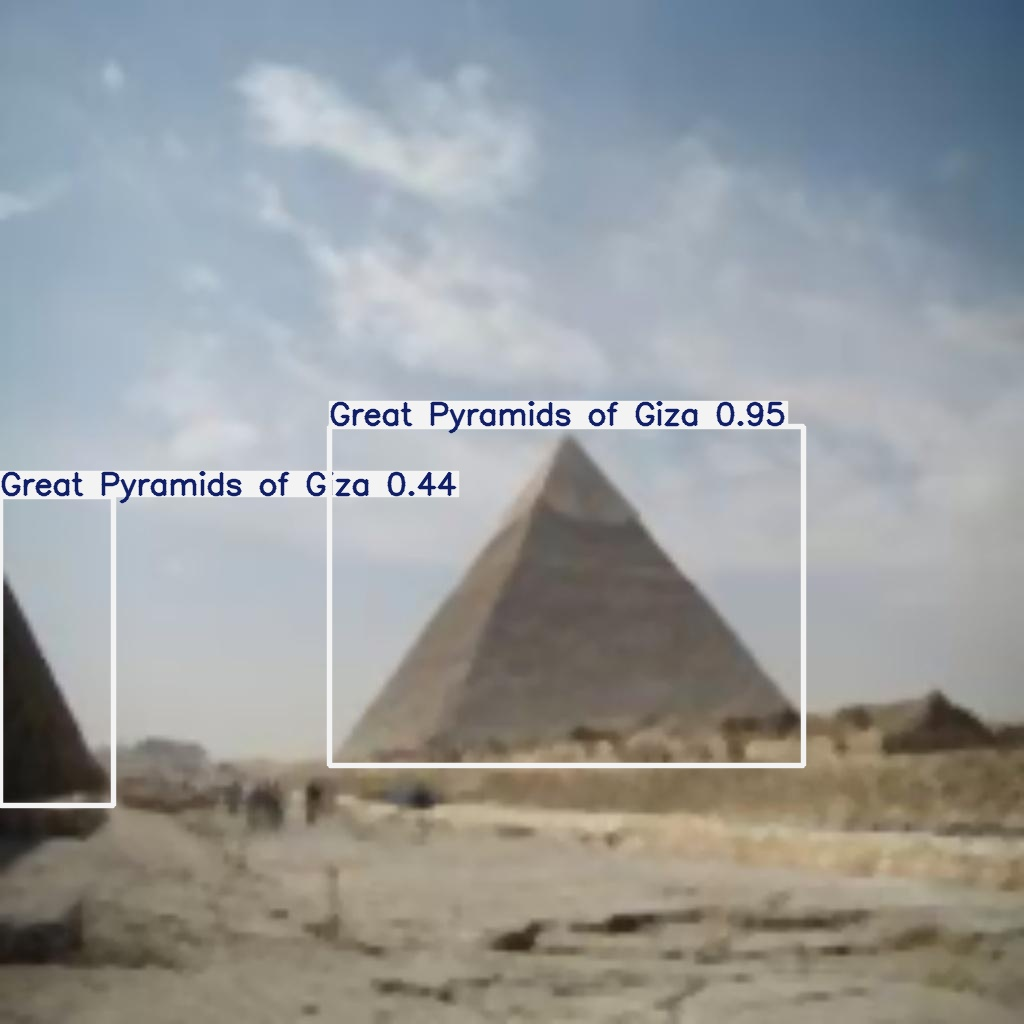

In [ ]:
Image('/content/yolo_train/log2/1_0-3-_jpg.rf.8752f5e14a64154e0a6d738a504b82fe.jpg',width=600)

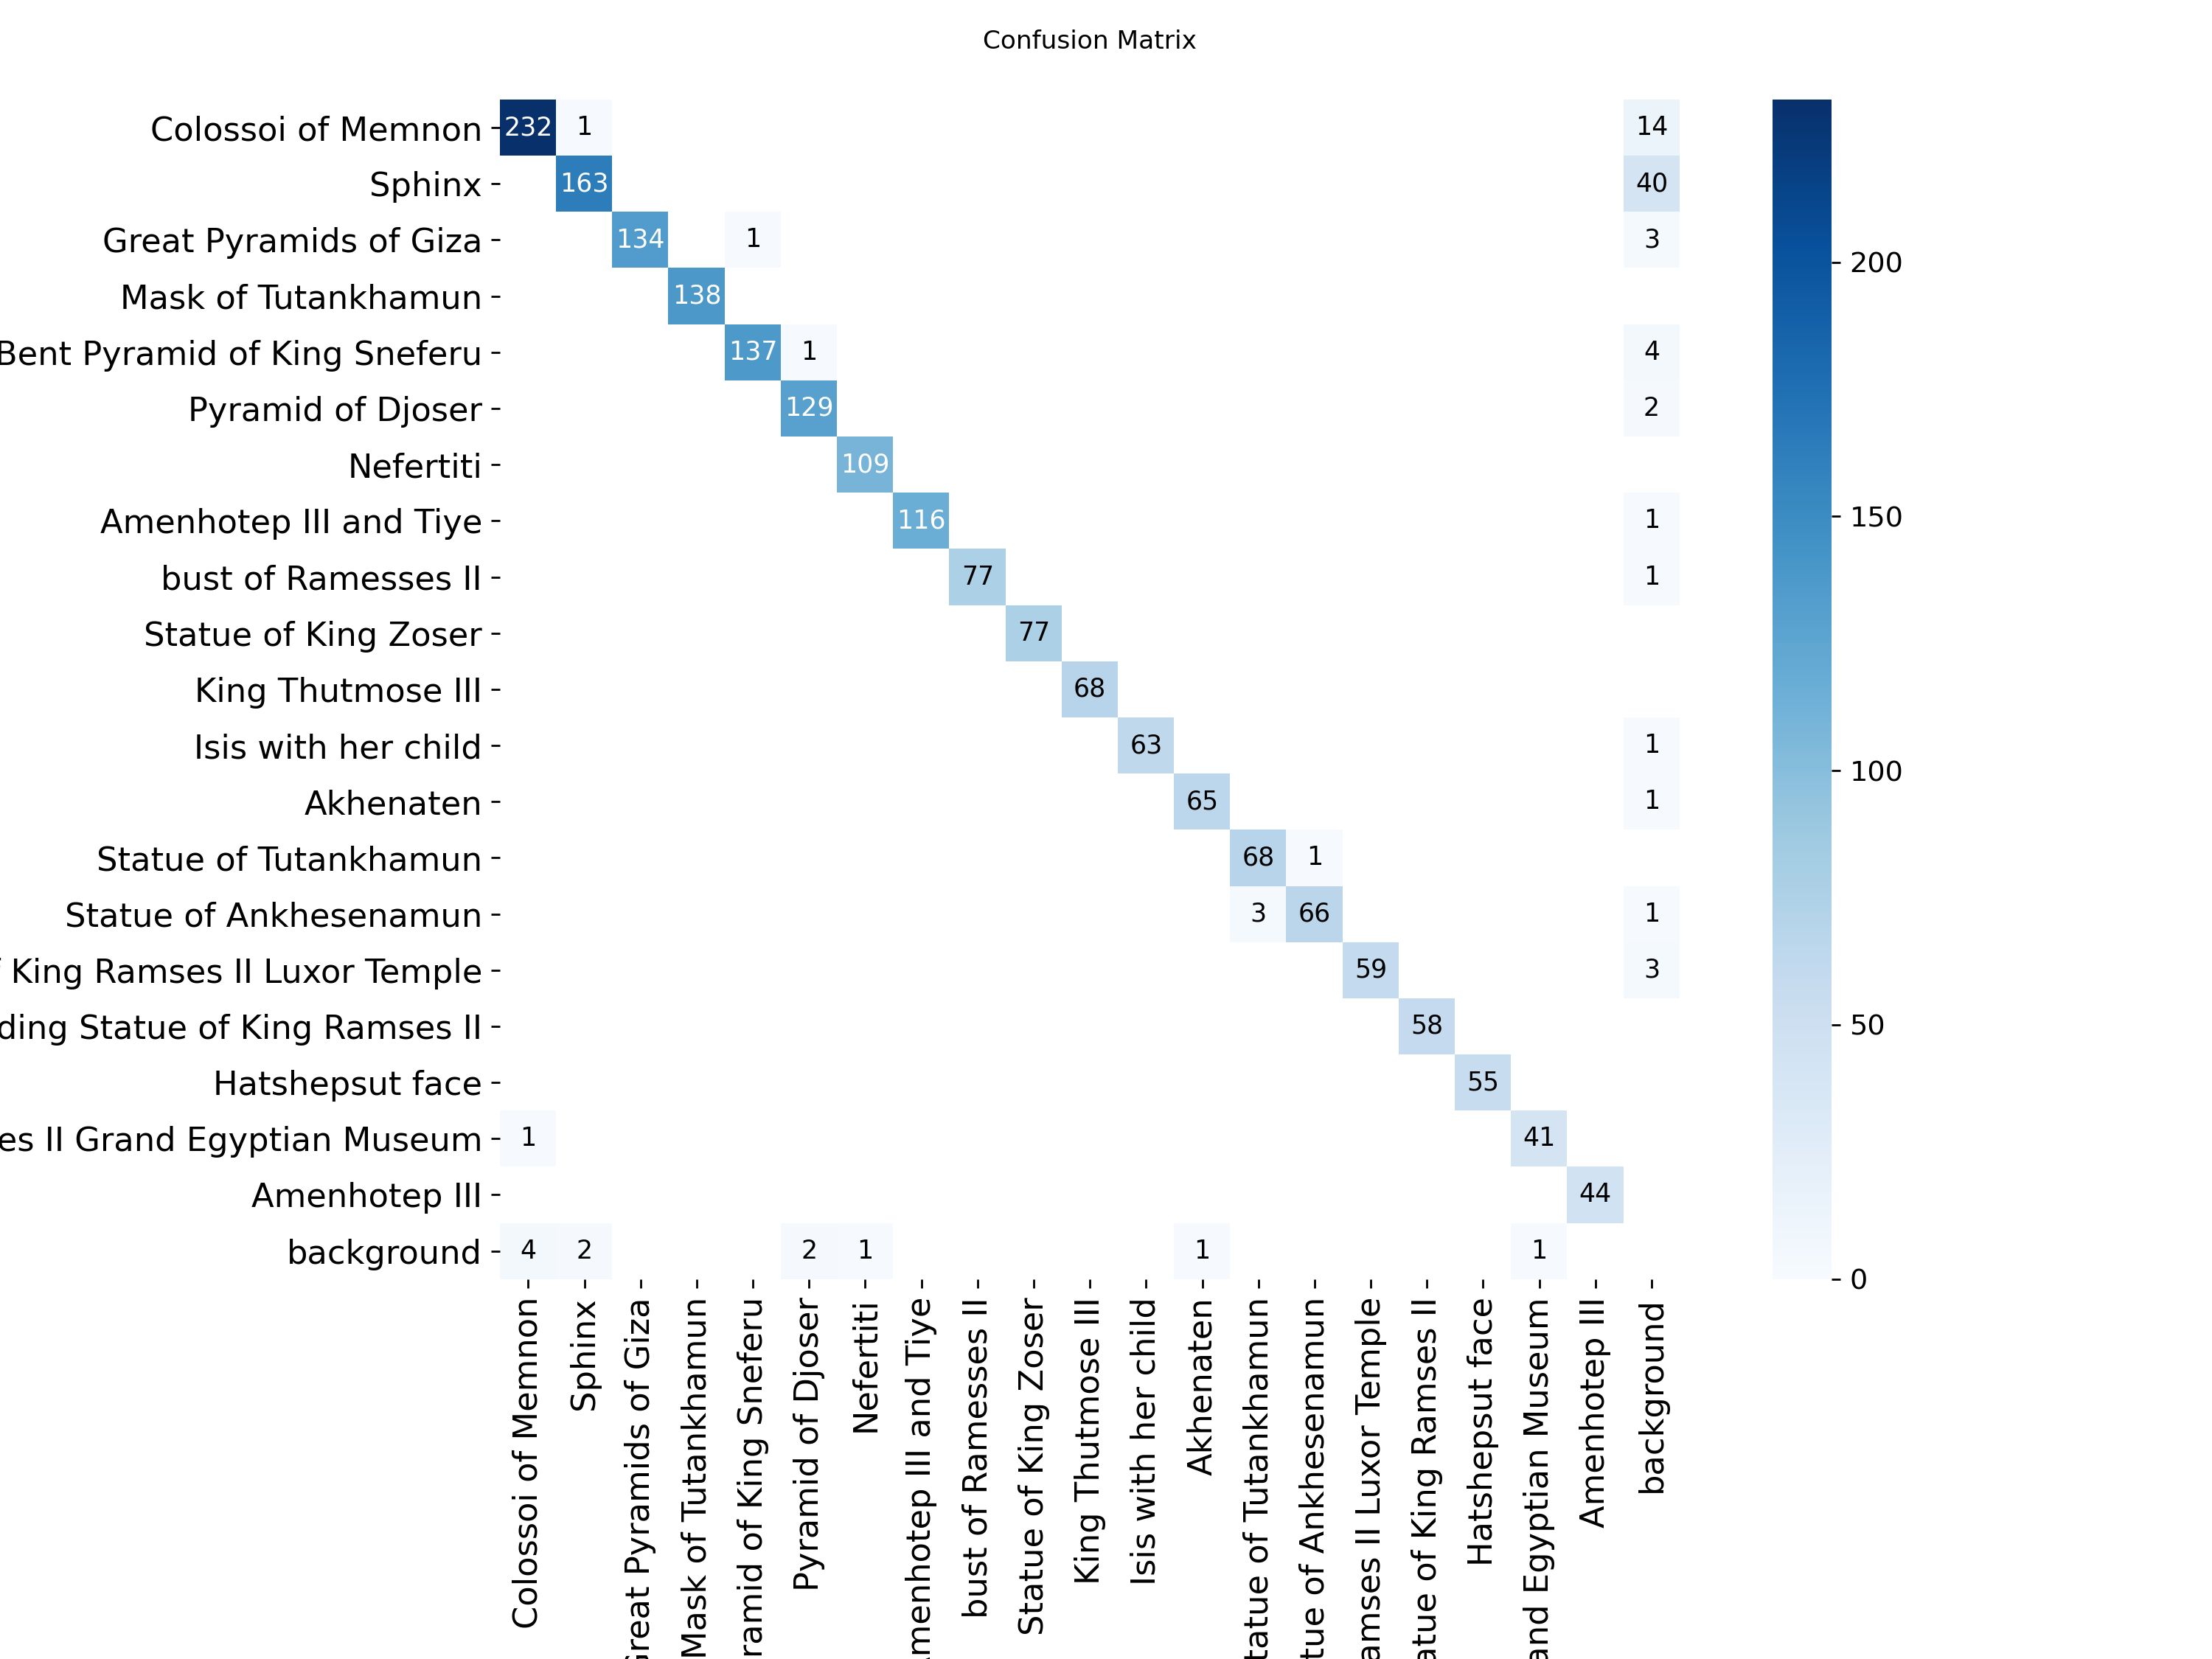

In [ ]:
Image('/content/yolo_train/log/confusion_matrix.png',width=600)

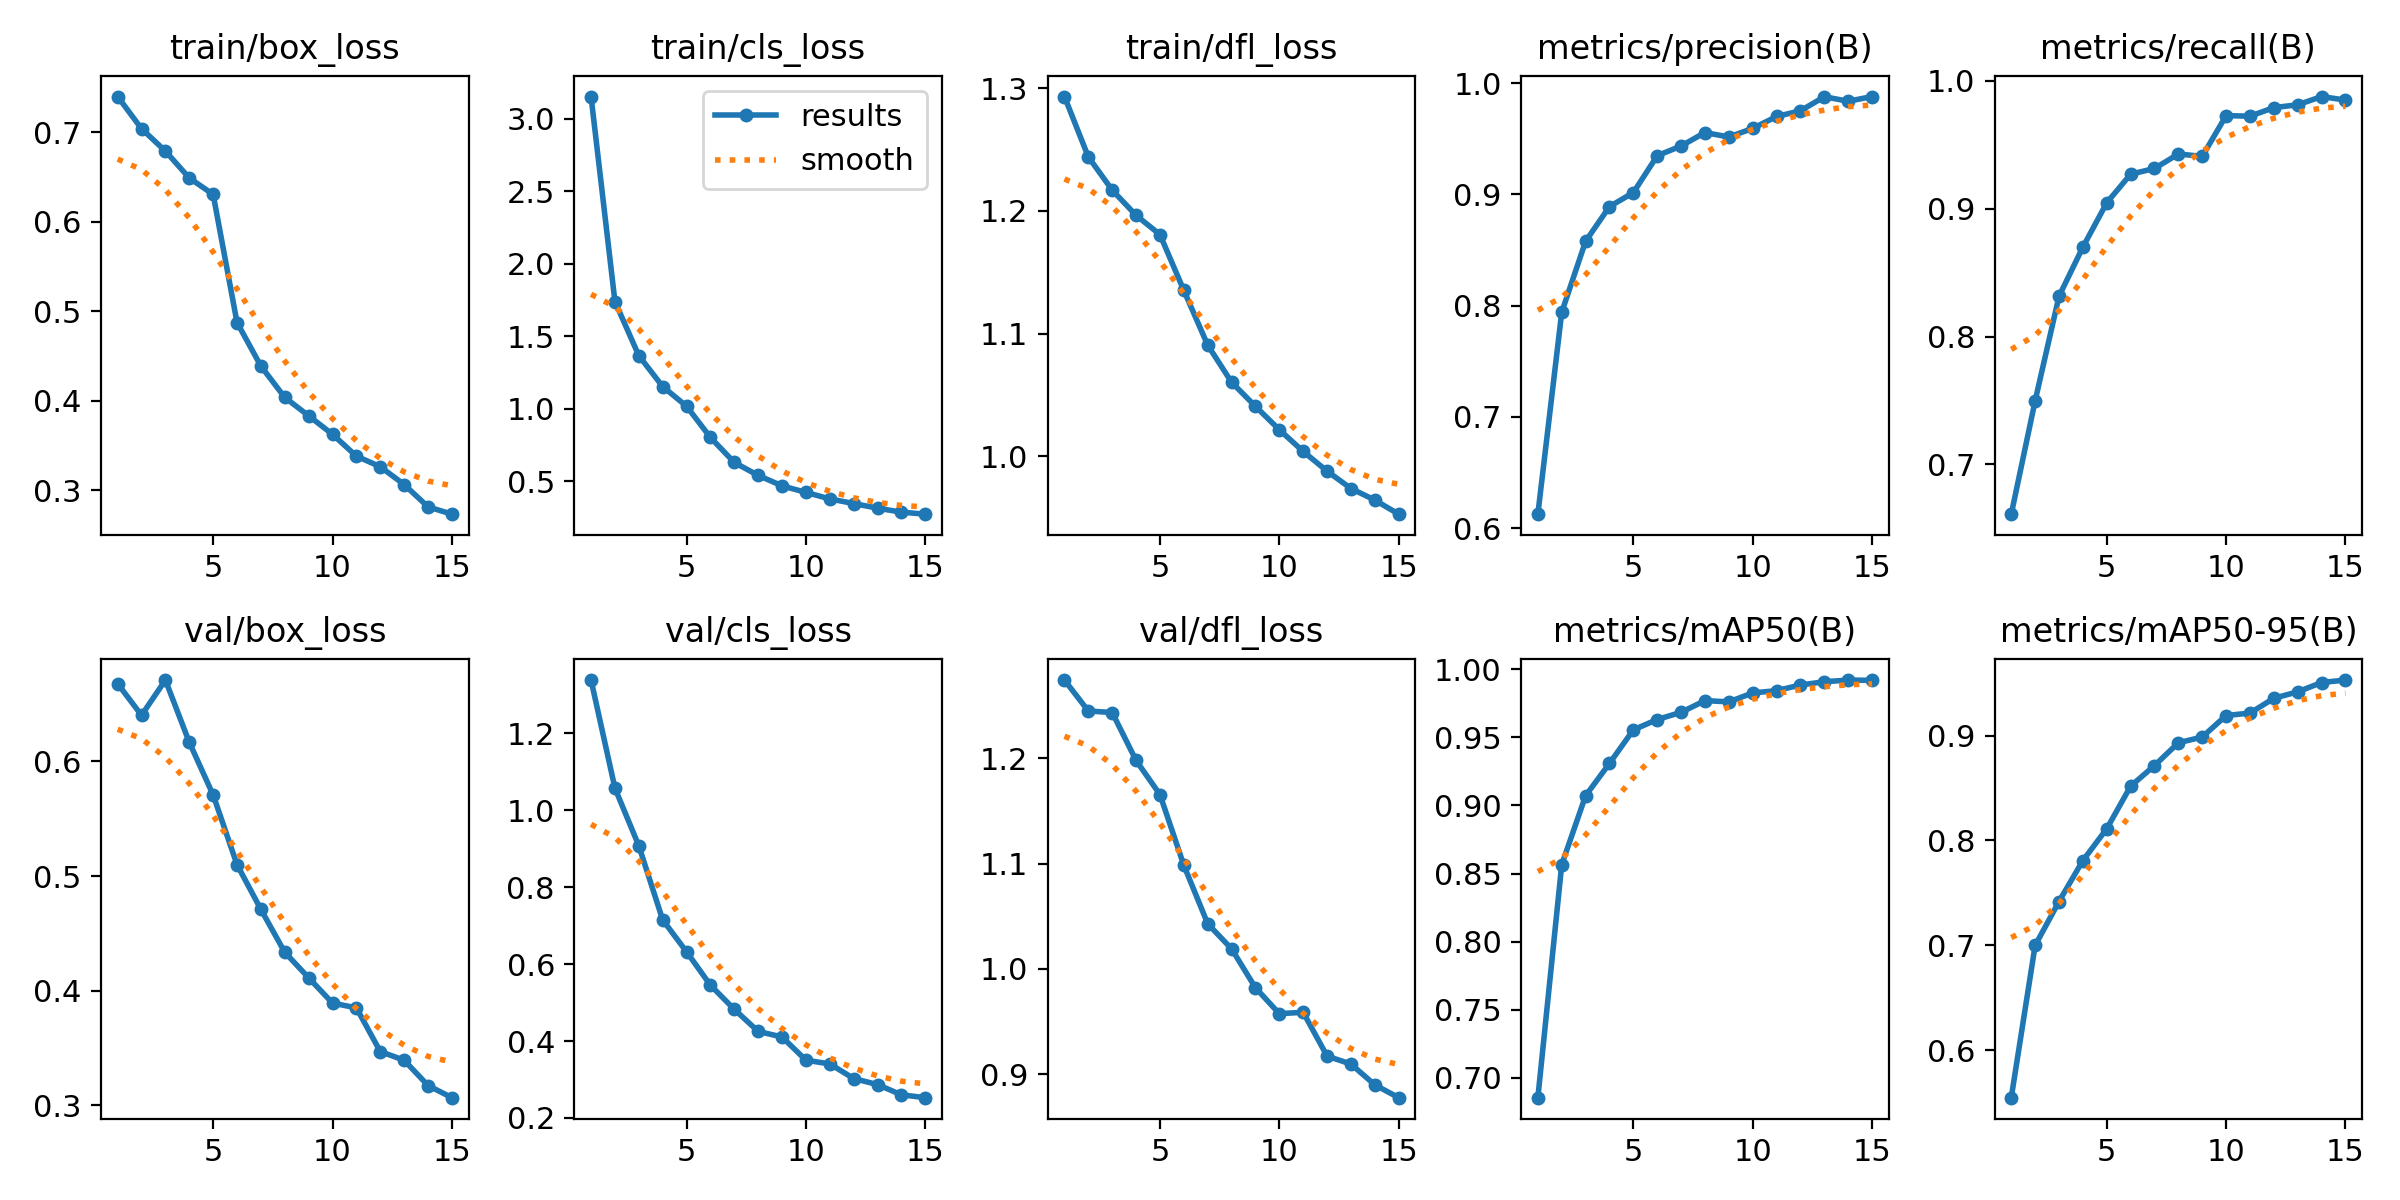

In [ ]:
Image('/content/yolo_train/log/results.png',width=600)